In [2]:
!pip install bertopic
!pip install sentence-transformers
!pip install hdbscan
!pip install umap-learn
!pip install plotly
!pip install wordcloud
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [5]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# BERTopic and related
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [8]:
from google.colab import files
print("📁 Please upload your JSON file (e.g., 000.json)")
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]
print(f"✅ Uploaded: {filename}")

# %%
# Load the JSON data
with open(filename, 'r') as f:
    data = json.load(f)

print(f"📊 JSON Structure:")
print(f"   Top-level keys: {list(data.keys())}")

📁 Please upload your JSON file (e.g., 000.json)


Saving 000.json to 000.json
✅ Uploaded: 000.json
📊 JSON Structure:
   Top-level keys: ['IE', 'ET', 'EA', 'LP']


In [9]:
def extract_texts_from_json(data):
    """
    Extract text documents from the CTI JSON structure.
    Creates multiple text representations for richer topic modeling.
    """
    documents = []
    metadata = []

    # Extract from typed triplets (ET section)
    typed_triplets = data.get('ET', {}).get('typed_triplets', [])

    for i, triplet in enumerate(typed_triplets):
        subject = triplet.get('subject', {})
        relation = triplet.get('relation', '')
        obj = triplet.get('object', {})

        subj_text = subject.get('text', '')
        subj_class = subject.get('class', '')
        obj_text = obj.get('text', '')
        obj_class = obj.get('class', '')

        # Create full sentence
        sentence = f"{subj_text} {relation} {obj_text}"
        documents.append(sentence)

        # Store metadata
        metadata.append({
            'index': i,
            'subject': subj_text,
            'subject_class': subj_class,
            'relation': relation,
            'object': obj_text,
            'object_class': obj_class,
            'sentence': sentence
        })

    return documents, metadata

# Extract texts
documents, metadata = extract_texts_from_json(data)
df_metadata = pd.DataFrame(metadata)

print(f"✅ Extracted {len(documents)} documents for topic modeling")
print(f"\n📝 Sample documents:")
for doc in documents[:5]:
    print(f"   • {doc}")

# %%
# Display metadata overview
print("\n📊 Entity Class Distribution:")
print("\nSubject Classes:")
print(df_metadata['subject_class'].value_counts())
print("\nObject Classes:")
print(df_metadata['object_class'].value_counts())
print("\nRelation Types:")
print(df_metadata['relation'].value_counts())


✅ Extracted 95 documents for topic modeling

📝 Sample documents:
   • Threat Actor Hades is backed by Russia
   • Threat Actor Hades uses WastedLocker
   • Threat Actor Hades uses Phoenix Locker
   • Threat Actor Hades uses PayloadBIN
   • Threat Actor Indrik Spider is also known as Evil Corp

📊 Entity Class Distribution:

Subject Classes:
subject_class
Attacker    57
Malware     38
Name: count, dtype: int64

Object Classes:
object_class
Tool                                 31
Malware                              28
Organization                         13
Attacker                              5
Infrastructure                        5
Malware Characteristic:Capability     3
Vulnerability                         3
Event                                 2
Credential                            2
Location                              1
Malware Characteristic:Feature        1
Malware Characteristic:Behavior       1
Name: count, dtype: int64

Relation Types:
relation
uses                 57
ta

In [10]:
embedding_model = SentenceTransformer('all-mpnet-base-v2')
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# Configure HDBSCAN for clustering
min_cluster = max(2, len(documents) // 20)
hdbscan_model = HDBSCAN(
    min_cluster_size=min_cluster,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Configure vectorizer for topic representation
vectorizer_model = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 2),  # Include bigrams
    min_df=1
)

print(f"✅ Models configured (min_cluster_size={min_cluster}) using all-mpnet-base-v2")

# Create and train BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    top_n_words=10,
    verbose=True,
    calculate_probabilities=True
)

# Fit the model
print("🚀 Training BERTopic model...")
topics, probs = topic_model.fit_transform(documents)
print("✅ Model training complete!")

2025-12-03 19:30:36,444 - BERTopic - Embedding - Transforming documents to embeddings.


✅ Models configured (min_cluster_size=4) using all-mpnet-base-v2
🚀 Training BERTopic model...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-12-03 19:30:41,306 - BERTopic - Embedding - Completed ✓
2025-12-03 19:30:41,307 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 19:30:42,437 - BERTopic - Dimensionality - Completed ✓
2025-12-03 19:30:42,439 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 19:30:42,460 - BERTopic - Cluster - Completed ✓
2025-12-03 19:30:42,469 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 19:30:42,495 - BERTopic - Representation - Completed ✓


✅ Model training complete!


In [11]:
# Get topic information
topic_info = topic_model.get_topic_info()
print("📊 Topic Overview:")
print(topic_info)

📊 Topic Overview:
    Topic  Count                                               Name  \
0      -1      1  -1_malware conti_mimikatz_uses mimikatz_conti ...   
1       0     13                  0_actor fin6_fin6_fin6 uses_actor   
2       1     13  1_trickbot_malware_malware trickbot_malware an...   
3       2      8       2_lead_actor lead_lead uses_agentemis threat   
4       3      8             3_actor hive_hive_hive targets_targets   
5       4      7  4_malware darkside_darkside_strike malware_dar...   
6       5      7          5_locker_macaw locker_macaw_malware macaw   
7       6      6        6_strike threat_cobalt strike_strike_cobalt   
8       7      6             7_actor conti_conti_cve_conti exploits   
9       8      6     8_malware lockbit_lockbit uses_lockbit_malware   
10      9      4       9_actor hades_hades_hades uses_backed russia   
11     10      4        10_spider_actor indrik_indrik spider_indrik   
12     11      4         11_hive uses_malware hive_hive_use

In [12]:
# Display detailed topic information
print("\n🔍 Detailed Topic Breakdown:\n")
for topic_id in topic_info['Topic'].unique():
    if topic_id == -1:
        print(f"Topic {topic_id} (Outliers): {topic_info[topic_info['Topic']==topic_id]['Count'].values[0]} documents")
    else:
        topic_words = topic_model.get_topic(topic_id)
        print(f"\n{'='*60}")
        print(f"Topic {topic_id}: {topic_info[topic_info['Topic']==topic_id]['Count'].values[0]} documents")
        print(f"{'='*60}")
        print("Top words:")
        for word, score in topic_words[:10]:
            print(f"   • {word}: {score:.4f}")


🔍 Detailed Topic Breakdown:

Topic -1 (Outliers): 1 documents

Topic 0: 13 documents
Top words:
   • actor fin6: 0.1687
   • fin6: 0.1687
   • fin6 uses: 0.1610
   • actor: 0.0767
   • threat: 0.0767
   • threat actor: 0.0767
   • mimikatz threat: 0.0726
   • uses: 0.0708
   • mimikatz: 0.0662
   • uses mimikatz: 0.0662

Topic 1: 13 documents
Top words:
   • trickbot: 0.1323
   • malware: 0.1108
   • malware trickbot: 0.1056
   • malware anchor_dns: 0.0800
   • anchor_dns: 0.0677
   • anchor_dns communicates: 0.0600
   • avaddon: 0.0600
   • trickbot malware: 0.0600
   • trickbot delivers: 0.0600
   • deployed trickbot: 0.0600

Topic 2: 8 documents
Top words:
   • lead: 0.2040
   • actor lead: 0.2040
   • lead uses: 0.2040
   • agentemis threat: 0.0889
   • agentemis: 0.0889
   • uses winnti: 0.0889
   • winnti threat: 0.0889
   • uses agentemis: 0.0889
   • winnti: 0.0889
   • uses bledoor: 0.0889

Topic 3: 8 documents
Top words:
   • actor hive: 0.2033
   • hive: 0.1709
   • hive ta

In [13]:
# Add topics to metadata dataframe
df_metadata['topic'] = topics
df_metadata['topic_probability'] = [max(p) if len(p) > 0 else 0 for p in probs]

print("\n📋 Documents with assigned topics:")
print(df_metadata[['sentence', 'topic', 'topic_probability']].head(10))



📋 Documents with assigned topics:
                                            sentence  topic  topic_probability
0             Threat Actor Hades is backed by Russia      9            1.00000
1               Threat Actor Hades uses WastedLocker      9            1.00000
2             Threat Actor Hades uses Phoenix Locker      9            1.00000
3                 Threat Actor Hades uses PayloadBIN      9            1.00000
4  Threat Actor Indrik Spider is also known as Ev...     10            1.00000
5             Threat Actor Indrik Spider uses Dridex     10            1.00000
6          Threat Actor Indrik Spider uses BitPaymer     10            1.00000
7       Threat Actor Indrik Spider uses WastedLocker     10            1.00000
8      Threat Actor Indrik Spider uses Cobalt Strike      6            1.00000
9                   Threat Actor Lead uses Agentemis      2            0.37366


In [14]:
# Topic Distribution Bar Chart
topic_counts = df_metadata['sentence'].value_counts().sort_index()
fig = px.bar(
    x=topic_counts.index.astype(str),
    y=topic_counts.values,
    labels={'x': 'Topic', 'y': 'Number of Documents'},
    title='📊 Document Distribution Across Topics',
    color=topic_counts.values,
    color_continuous_scale='Blues'
)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
# Interactive Topic Visualization (Intertopic Distance Map)
try:
    fig_topics = topic_model.visualize_topics()
    fig_topics.show()
except Exception as e:
    print(f"⚠️ Could not generate intertopic distance map: {e}")


In [17]:
# Topic Word Scores (Barchart)
try:
    fig_barchart = topic_model.visualize_barchart(top_n_topics=10, n_words=8,topic_model.set_topic_labels())
    fig_barchart.show()
except Exception as e:
    print(f"⚠️ Could not generate barchart: {e}")

In [23]:
# Build a mapping for: topic number → representative sentence
topic_sentence_labels = (
    df_metadata.groupby("topic")["sentence"]
    .apply(lambda x: x.iloc[0])   # or x.mode()[0] / longest / best sentence
    .to_dict()
)

topic_sentence_labels

{-1: 'Malware Conti uses Mimikatz',
 0: 'Threat Actor FIN6 uses Anchor_DNS',
 1: 'Malware TrickBot is delivered by phishing campaigns',
 2: 'Threat Actor Lead uses Agentemis',
 3: 'Threat Actor Hive targets Healthcare',
 4: 'Malware TrickBot uses Cobalt Strike',
 5: 'Malware SocGholish is used by Evil Corp',
 6: 'Threat Actor Indrik Spider uses Cobalt Strike',
 7: 'Threat Actor Conti targets First Responders',
 8: 'Malware SocGholish delivers WastedLocker ransomware',
 9: 'Threat Actor Hades is backed by Russia',
 10: 'Threat Actor Indrik Spider is also known as Evil Corp',
 11: 'Malware Hive uses double-extortion',
 12: 'Threat Actor Evil Corp uses SocGholish',
 13: 'Threat Actor LockBit targets Healthcare'}

In [40]:


fig_barchart = topic_model.visualize_barchart(
    top_n_topics=10,
    n_words=8,
    custom_labels = topic_sentence_labels,
     width=400,
    height=200
)

fig_barchart.show()



In [ ]:
# Topic Hierarchy (Dendrogram)
try:
    fig_hierarchy = topic_model.visualize_hierarchy()
    fig_hierarchy.show()
except Exception as e:
    print(f"⚠️ Could not generate hierarchy: {e}")


In [ ]:
# Document-Topic Heatmap
try:
    fig_heatmap = topic_model.visualize_heatmap()
    fig_heatmap.show()
except Exception as e:
    print(f"⚠️ Could not generate heatmap: {e}")


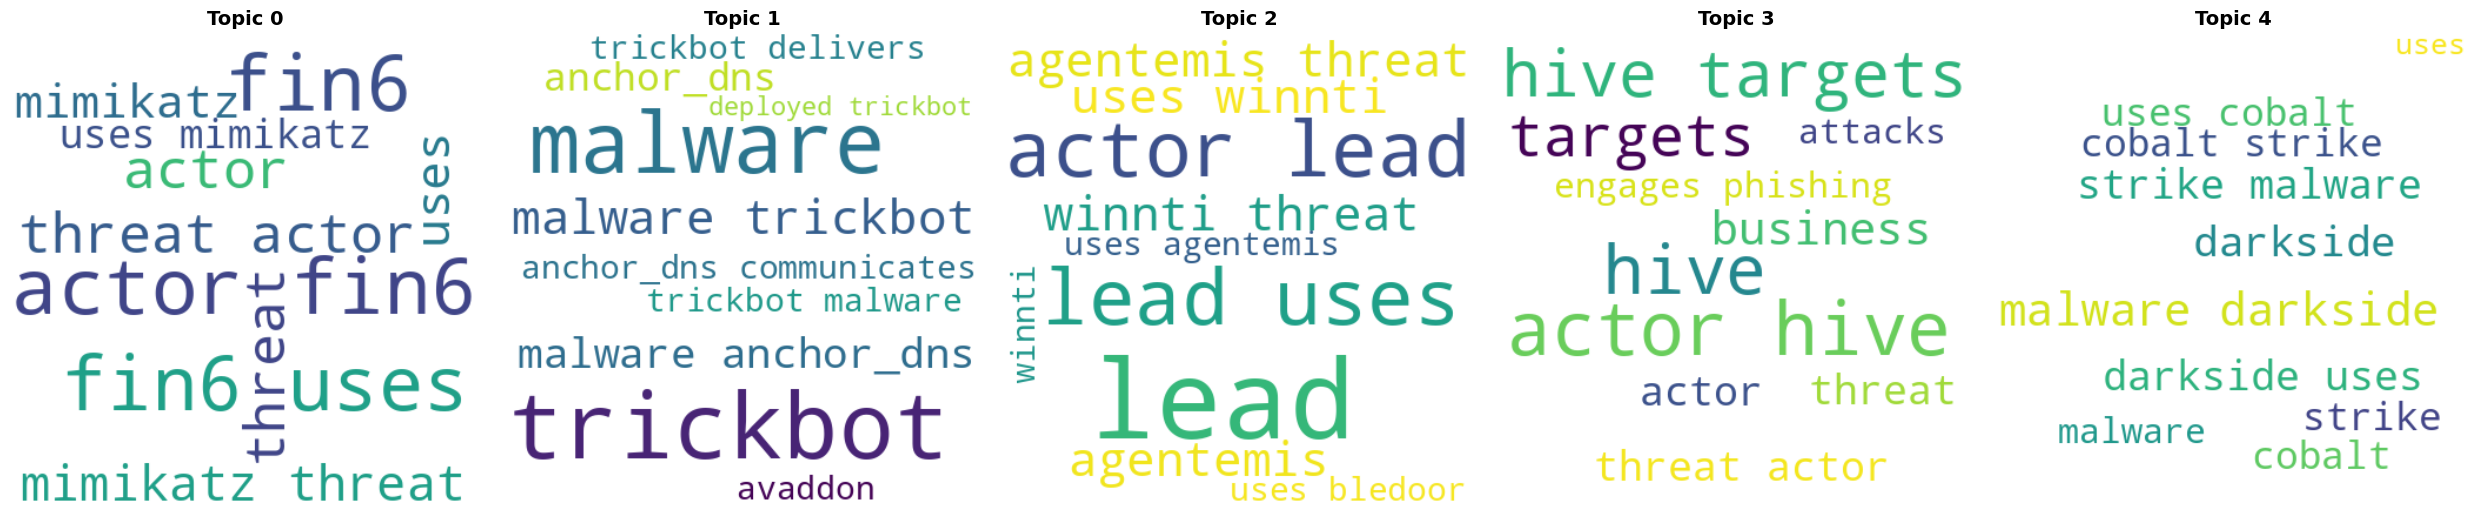

✅ Word clouds saved to 'topic_wordclouds.png'


In [ ]:
# Word Clouds for Each Topic
def generate_topic_wordclouds(topic_model, num_topics=5):
    """Generate word clouds for top topics"""
    topics_to_plot = [t for t in topic_model.get_topic_info()['Topic'].values if t != -1][:num_topics]

    if len(topics_to_plot) == 0:
        print("⚠️ No valid topics found for word clouds")
        return

    fig, axes = plt.subplots(1, len(topics_to_plot), figsize=(5*len(topics_to_plot), 5))

    if len(topics_to_plot) == 1:
        axes = [axes]

    for ax, topic_id in zip(axes, topics_to_plot):
        topic_words = dict(topic_model.get_topic(topic_id))

        # Ensure all values are positive
        topic_words = {k: abs(v) for k, v in topic_words.items()}

        wc = WordCloud(
            width=400,
            height=400,
            background_color='white',
            colormap='viridis'
        ).generate_from_frequencies(topic_words)

        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f'Topic {topic_id}', fontsize=14, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('topic_wordclouds.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Word clouds saved to 'topic_wordclouds.png'")

generate_topic_wordclouds(topic_model)

In [ ]:
# Topic Distribution by Entity Class
fig = px.histogram(
    df_metadata,
    x='topic',
    color='subject_class',
    title='📊 Topic Distribution by Subject Entity Class',
    barmode='group',
    labels={'topic': 'Topic', 'count': 'Count', 'subject_class': 'Entity Class'}
)
fig.show()

In [ ]:
# 2D Document Embeddings Visualization
try:
    fig_docs = topic_model.visualize_documents(
        documents,
        topics=topics,
        hide_annotations=True,
        hide_document_hover=False
    )
    fig_docs.show()
except Exception as e:
    print(f"⚠️ Could not generate document visualization: {e}")

    # Alternative: Manual 2D visualization
    print("Creating alternative 2D visualization...")
    embeddings = embedding_model.encode(documents)
    umap_2d = UMAP(n_components=2, random_state=42)
    embeddings_2d = umap_2d.fit_transform(embeddings)

    df_viz = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'topic': [str(t) for t in topics],
        'document': documents
    })

    fig = px.scatter(
        df_viz,
        x='x', y='y',
        color='topic',
        hover_data=['document'],
        title='📍 Document Embeddings (2D UMAP Projection)',
        labels={'x': 'UMAP 1', 'y': 'UMAP 2'}
    )
    fig.show()

In [ ]:
# Analyze topics by relation type
print("🔍 Topics by Relation Type:\n")
relation_topic_analysis = df_metadata.groupby(['relation', 'topic']).size().unstack(fill_value=0)
print(relation_topic_analysis)

🔍 Topics by Relation Type:

topic              -1    0    1    2    3    4    5    6    7    8    9    10  \
relation                                                                        
attacked             0    0    0    0    0    0    0    0    0    0    0    0   
attacks              0    0    0    0    1    0    0    0    0    0    0    0   
avoids               0    0    0    0    0    0    0    0    0    0    0    0   
communicates over    0    0    2    0    0    0    0    0    0    0    0    0   
delivers             0    0    2    0    0    1    0    0    0    1    0    0   
deployed by          0    0    1    0    0    0    0    0    0    0    0    0   
deploys              0    1    0    0    0    0    0    0    0    0    0    0   
engages in           0    0    0    0    1    0    0    0    0    0    0    0   
exploits             0    0    0    0    0    0    0    0    3    0    0    0   
is also known as     0    0    0    0    0    0    0    0    0    0    0    1   


In [ ]:
# Find representative documents for each topic
print("\n📄 Representative Documents per Topic:\n")
for topic_id in sorted(df_metadata['topic'].unique()):
    if topic_id == -1:
        continue
    print(f"\n{'='*60}")
    print(f"Topic {topic_id}")
    print(f"{'='*60}")

    topic_docs = df_metadata[df_metadata['topic'] == topic_id].nlargest(3, 'topic_probability')
    for _, row in topic_docs.iterrows():
        print(f"   • {row['sentence']} (prob: {row['topic_probability']:.3f})")


📄 Representative Documents per Topic:


Topic 0
   • Threat Actor FIN6 uses Mimikatz (prob: 1.000)
   • Threat Actor FIN6 uses Ryuk (prob: 1.000)
   • Threat Actor FIN6 uses Mimikatz (prob: 1.000)

Topic 1
   • Malware TrickBot is delivered by phishing campaigns (prob: 1.000)
   • Malware TrickBot uses JavaScript Downloader (prob: 1.000)
   • Malware Anchor is deployed by TrickBot (prob: 1.000)

Topic 2
   • Threat Actor Lead uses BleDoor (prob: 1.000)
   • Threat Actor Lead uses Winnti (prob: 1.000)
   • Threat Actor Lead uses RbDoor (prob: 1.000)

Topic 3
   • Threat Actor Hive targets Transportation (prob: 1.000)
   • Threat Actor Hive targets Technology (prob: 1.000)
   • Threat Actor Hive targets Insurance (prob: 1.000)

Topic 4
   • Malware DarkSide uses Salsa20 (prob: 1.000)
   • Malware DarkSide uses RSA-1024 (prob: 1.000)
   • Malware DarkSide delivers data leak sites (prob: 1.000)

Topic 5
   • Malware Phoenix Locker is deployed by Evil Corp (prob: 1.000)
   • Malware Payloa

In [ ]:
# Topic Labels (Auto-generated)
print("\n🏷️ Suggested Topic Labels:\n")
topic_labels = topic_model.generate_topic_labels(nr_words=3, separator=' | ')
for topic_id, label in enumerate(topic_labels):
    if topic_id == 0:
        print(f"Topic -1 (Outliers): Miscellaneous")
    else:
        print(f"Topic {topic_id-1}: {label}")


🏷️ Suggested Topic Labels:

Topic -1 (Outliers): Miscellaneous
Topic 0: 0 | actor fin6 | fin6 | fin6 uses
Topic 1: 1 | trickbot | malware | malware trickbot
Topic 2: 2 | lead | actor lead | lead uses
Topic 3: 3 | actor hive | hive | hive targets
Topic 4: 4 | malware darkside | darkside | strike malware
Topic 5: 5 | locker | macaw locker | macaw
Topic 6: 6 | strike threat | cobalt strike | strike
Topic 7: 7 | actor conti | conti | cve
Topic 8: 8 | malware lockbit | lockbit uses | lockbit
Topic 9: 9 | actor hades | hades | hades uses
Topic 10: 10 | spider | actor indrik | indrik spider
Topic 11: 11 | hive uses | malware hive | hive
Topic 12: 12 | actor darkside | darkside | attacked colonial
Topic 13: 13 | actor lockbit | lockbit | lockbit targets


In [ ]:
# Save topic assignments to CSV
df_metadata.to_csv('cti_topic_assignments.csv', index=False)
print("✅ Saved topic assignments to 'cti_topic_assignments.csv'")

# Save topic information
topic_info.to_csv('cti_topic_info.csv', index=False)
print("✅ Saved topic info to 'cti_topic_info.csv'")

# Save the model for later use
topic_model.save("cti_bertopic_model")
print("✅ Saved BERTopic model to 'cti_bertopic_model'")

# Download all results
from google.colab import files

# Create a summary report
summary = f"""
# CTI BERTopic Analysis Summary
# ==============================

Total Documents Analyzed: {len(documents)}
Number of Topics Found: {len(topic_info) - 1}  # Excluding outliers
Outlier Documents: {len(df_metadata[df_metadata['topic'] == -1])}

## Topic Overview:
{topic_info.to_string()}

## Top Words per Topic:
"""

for topic_id in sorted(topic_info['Topic'].unique()):
    if topic_id != -1:
        words = topic_model.get_topic(topic_id)
        summary += f"\nTopic {topic_id}: {', '.join([w for w, _ in words[:5]])}"

with open('cti_bertopic_summary.txt', 'w') as f:
    f.write(summary)

print("✅ Saved summary to 'cti_bertopic_summary.txt'")

# %%
# Download files
print("\n📥 Downloading result files...")
files.download('cti_topic_assignments.csv')
files.download('cti_topic_info.csv')
files.download('cti_bertopic_summary.txt')
files.download('topic_wordclouds.png')

2025-12-01 03:36:53,321 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


✅ Saved topic assignments to 'cti_topic_assignments.csv'
✅ Saved topic info to 'cti_topic_info.csv'
✅ Saved BERTopic model to 'cti_bertopic_model'
✅ Saved summary to 'cti_bertopic_summary.txt'

📥 Downloading result files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import networkx as nx
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from collections import Counter

# ========= 1. Load the GraphML =========

graph_path = "threat_intel_graph.graphml"  # adjust path if needed
G = nx.read_graphml(graph_path)

print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# ========= 2. Build a document corpus from nodes =========
# We’ll build one short text per node + keep metadata
docs = []
meta = []

for node_id, attrs in G.nodes(data=True):
    # Try common attribute names; adjust to your schema if needed
    name = attrs.get("name") or attrs.get("label") or attrs.get("id") or ""
    desc = attrs.get("description") or attrs.get("text") or ""
    etype = (attrs.get("entity_type") or attrs.get("type") or "").lower()

    # Skip empty ones
    if not name and not desc:
        continue

    # Simple text representation: name + description
    text = f"{name}. {desc}".strip()
    docs.append(text)
    meta.append({
        "node_id": node_id,
        "name": name,
        "entity_type": etype,
    })

print(f"Prepared {len(docs)} documents for BERTopic.")

meta_df = pd.DataFrame(meta)

# ========= 3. Run BERTopic =========

embedding_model = SentenceTransformer("all-mpnet-base-v2")

topic_model = BERTopic(
    embedding_model=embedding_model,
    min_topic_size=5,        # adjust depending on graph size
    verbose=True
)

topics, probs = topic_model.fit_transform(docs)

topic_info = topic_model.get_topic_info()
print(topic_info.head())

# Attach topic assignments to metadata
meta_df["topic"] = topics

# ========= 4. Helper: categorize node types (adversary, malware, sector) =========
# Adjust these keywords to match actual values you use in the KG
adversary_keywords = ["threat_actor", "actor", "group", "apt", "adversary"]
malware_keywords   = ["malware", "ransomware", "tool", "implant", "backdoor", "loader"]
sector_keywords    = ["industry", "sector", "vertical", "victim_sector", "victim_industry"]

def categorize_entity(etype: str):
    etype_l = etype.lower()
    if any(k in etype_l for k in adversary_keywords):
        return "adversary"
    if any(k in etype_l for k in malware_keywords):
        return "malware"
    if any(k in etype_l for k in sector_keywords):
        return "sector"
    return "other"

meta_df["category"] = meta_df["entity_type"].apply(categorize_entity)

# ========= 5. Dominating adversaries =========

adversaries = meta_df[meta_df["category"] == "adversary"]
adv_counts = (
    adversaries["name"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "adversary", "name": "count"})
)

print("\nTop adversaries (by frequency in KG):")
print(adv_counts.head(10))

# ========= 6. Dominating malware / tools =========

malware = meta_df[meta_df["category"] == "malware"]
mal_counts = (
    malware["name"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "malware", "name": "count"})
)

print("\nTop malware / tools (by frequency in KG):")
print(mal_counts.head(10))

# ========= 7. Most affected sectors / industries =========

sectors = meta_df[meta_df["category"] == "sector"]
sec_counts = (
    sectors["name"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "sector", "name": "count"})
)

print("\nTop targeted sectors (by frequency in KG):")
print(sec_counts.head(10))

# ========= 8. (Optional) Topic-level breakdown =========
# Which topics are dominated by which actors/malware/sectors?

# Adversaries per topic
adv_topic_counts = (
    adversaries.groupby(["topic", "name"])
    .size()
    .reset_index(name="count")
    .sort_values(["topic", "count"], ascending=[True, False])
)

# Malware per topic
mal_topic_counts = (
    malware.groupby(["topic", "name"])
    .size()
    .reset_index(name="count")
    .sort_values(["topic", "count"], ascending=[True, False])
)

# Sectors per topic
sec_topic_counts = (
    sectors.groupby(["topic", "name"])
    .size()
    .reset_index(name="count")
    .sort_values(["topic", "count"], ascending=[True, False])
)

# ========= 9. Save for slides / further analysis =========

adv_counts.to_csv("top_adversaries.csv", index=False)
mal_counts.to_csv("top_malware.csv", index=False)
sec_counts.to_csv("top_sectors.csv", index=False)

adv_topic_counts.to_csv("adversaries_by_topic.csv", index=False)
mal_topic_counts.to_csv("malware_by_topic.csv", index=False)
sec_topic_counts.to_csv("sectors_by_topic.csv", index=False)

print("\nSaved CSVs: top_adversaries.csv, top_malware.csv, top_sectors.csv, and topic breakdowns.")

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Loaded graph with 89 nodes and 88 edges
Prepared 89 documents for BERTopic.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-12-03 19:01:33,802 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-12-03 19:01:36,974 - BERTopic - Embedding - Completed ✓
2025-12-03 19:01:36,976 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 19:01:50,124 - BERTopic - Dimensionality - Completed ✓
2025-12-03 19:01:50,128 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 19:01:50,171 - BERTopic - Cluster - Completed ✓
2025-12-03 19:01:50,187 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 19:01:50,229 - BERTopic - Representation - Completed ✓


   Topic  Count                                        Name  \
0     -1     30                    -1_1024_1472_2020_adfind   
1      0     31  0_malware_ransomware_wastedlocker_phishing   
2      1     13        1_business_education_double_colonial   
3      2     10                   2_threat_actor_hades_fin6   
4      3      5           3_mimikatz_bledoor_salsa20_rclone   

                                      Representation  \
0  [1024, 1472, 2020, adfind, agentemis, anydesk,...   
1  [malware, ransomware, wastedlocker, phishing, ...   
2  [business, education, double, colonial, and, e...   
3  [threat, actor, hades, fin6, spider, indrik, l...   
4  [mimikatz, bledoor, salsa20, rclone, dridex, ,...   

                                 Representative_Docs  
0  [CVE-2020-1472., LSASS credential dumping., cu...  
1  [Malware Anchor_DNS., Malware Conti., Malware ...  
2  [Business Services., medical, educational non-...  
3  [Threat Actor Hive., Threat Actor Conti., Thre...  
4        